# Model 1: Functional model of BLA
1. target behavioral data
    - conditioned freezing
    - extinction-induced reduction of freezing
    - renewal of freezing when the CS is presented in the original context
2. target activity data
    - BLA fear neurons become CS-responsive after conditioning and lose CS-responsiveness after extinction
    - BLA extinction neurons become CS-responsive after extinction
    - BLA persistant neurons become CS-responsive after conditioning and maintain their activity after extinction

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = nengo.dists.UniformHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
    def get_CS(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        self.CS = self.CSs[idx] if applied else np.zeros((self.dim_CS))
        return self.CS
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    
dt = 0.001
nCond = 5
nExt = 5
seed = 0
nNeurons = 100
dim_CS = 3
dim_CTX = 10
nCTX = 2
inputs = Inputs(nCS=1, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, seed=seed)
intercepts_pos = nengo.dists.Uniform(0, 1)
encoders_pos = nengo.dists.Choice([[1]])
encoders_ctx = nengo.dists.Choice(inputs.CTXs)
intercepts_ctx = [(np.dot(inputs.CTXs, inputs.CTXs.T) - np.eye(nCTX)).flatten().max()]*dim_CTX*nNeurons
dInh = -2e0*np.ones((nNeurons, 1))

## Version 1: use PES learning to update connections weights from CS to BLA, such that BLA's CS response increases when the US is present alongside the CS

In [3]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    # amygdala ensembles
    BLA = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
    gate = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    freeze = nengo.Ensemble(nNeurons, 1)  # [freeze]
    # error ensembles
    error_CS_fear = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, gate[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, gate[1])
    # learned connections
    conditioning = nengo.Connection(external_CS, BLA[0], function=lambda x: 0, learning_rule_type=nengo.PES(1e-4))
    nengo.Connection(external_US, BLA[1])
    # error connections
    nengo.Connection(BLA, error_CS_fear, function=lambda x: x[1]-x[0])  # US - (CS response)
    # error gating
    nengo.Connection(gate, error_CS_fear.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    # error updating
    nengo.Connection(error_CS_fear, conditioning.learning_rule, transform=-1)
    # output connections
    nengo.Connection(BLA[0], freeze)  # CS response added to freeze response
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pBLA_spikes = nengo.Probe(BLA.neurons)
    pBLA = nengo.Probe(BLA)
    pGate = nengo.Probe(gate)
    pError_CS_fear = nengo.Probe(error_CS_fear)
    pFreeze = nengo.Probe(freeze)

In [4]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


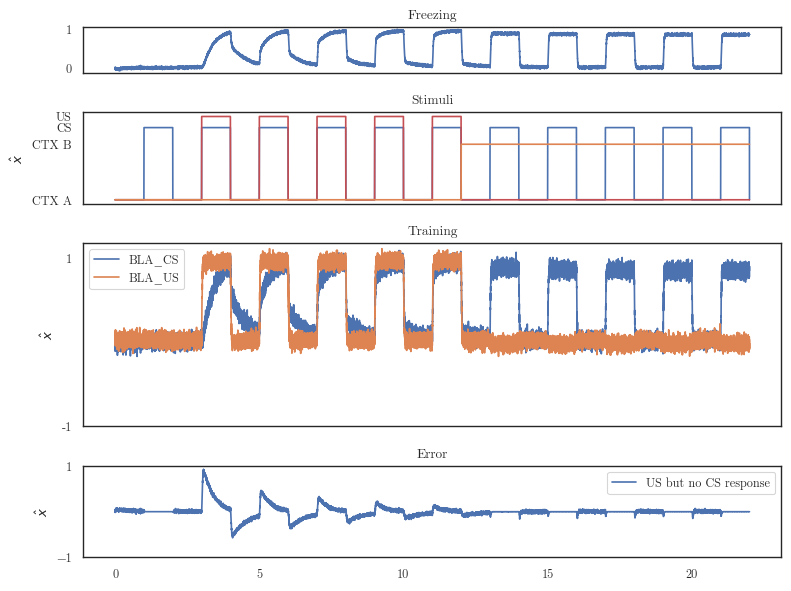

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [1,2,4,2]})
axes[0].plot(sim.trange(), sim.data[pFreeze])
axes[0].set(yticks=((0, 1)), ylabel=None, title="Freezing")
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[pBLA][:,0], label="BLA_CS")
axes[2].plot(sim.trange(), sim.data[pBLA][:,1], label="BLA_US")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
axes[3].plot(sim.trange(), sim.data[pError_CS_fear], label="US but no CS response")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((-1,1)))
plt.tight_layout()

## Version 2: Use PES learning to update connection between CTX and BLA, such that BLA's CTX response decreases when the BLA's CS response is high but no US is present.

In [6]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_ctx, encoders=encoders_ctx)
    # amygdala ensembles
    BLA = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
    gate = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    freeze = nengo.Ensemble(nNeurons, 1)  # [freeze]
    # error ensembles
    error_CS_fear = nengo.Ensemble(nNeurons, 1)
    error_CTX_safe = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)

    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(CTX, external_CTX, synapse=None)
    nengo.Connection(external_CS, gate[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, gate[1])
    # learned connections
    conditioning = nengo.Connection(external_CS, BLA[0], function=lambda x: 0, learning_rule_type=nengo.PES(1e-4))
    nengo.Connection(external_US, BLA[1])
    extinction = nengo.Connection(external_CTX, BLA[2], function=lambda x: 0, learning_rule_type=nengo.PES(1e-5))
    # error connections
    nengo.Connection(BLA, error_CS_fear, function=lambda x: x[1]-x[0])  # US - (CS response)
    nengo.Connection(BLA, error_CTX_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
    # error gating
    nengo.Connection(gate, error_CS_fear.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS
    nengo.Connection(gate, error_CTX_safe.neurons, function=lambda x: 1-x[0]+x[1], transform=dInh)  # inhibit by default; release if CS without US
    # error update
    nengo.Connection(error_CS_fear, conditioning.learning_rule, transform=-1)
    nengo.Connection(error_CTX_safe, extinction.learning_rule, transform=1)
    # output connections
    nengo.Connection(BLA[0], freeze, transform=1)  # CS response added to freeze response
    nengo.Connection(BLA[2], freeze, transform=1)  # CTX response added to freeze response

    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pBLA_spikes = nengo.Probe(BLA.neurons)
    pBLA = nengo.Probe(BLA)
    pError_CS_fear = nengo.Probe(error_CS_fear)
    pError_CTX_safe = nengo.Probe(error_CTX_safe)
    pFreeze = nengo.Probe(freeze)

In [7]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


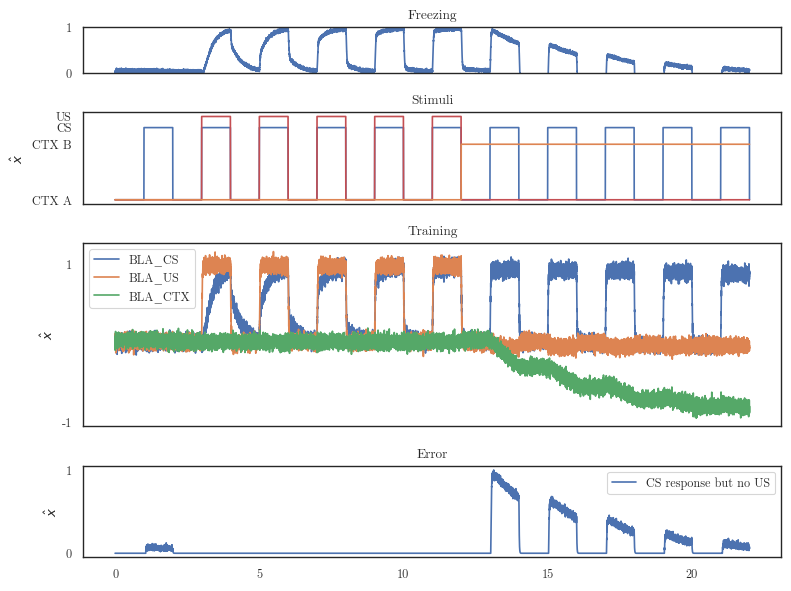

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [1,2,4,2]})
axes[0].plot(sim.trange(), sim.data[pFreeze])
axes[0].set(yticks=((0, 1)), ylim=((0,1)), ylabel=None, title="Freezing")
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[pBLA][:,0], label="BLA_CS")
axes[2].plot(sim.trange(), sim.data[pBLA][:,1], label="BLA_US")
axes[2].plot(sim.trange(), sim.data[pBLA][:,2], label="BLA_CTX")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
# axes[3].plot(sim.trange(), sim.data[pError_CS_fear], label="US but no CS response")
axes[3].plot(sim.trange(), sim.data[pError_CTX_safe], label="CS response but no US")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()

## Version 3: Use PES learning to update connection between CTX and BLA, such that BLA's CTX response increases when the CS is present alongside the US

In [9]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_ctx, encoders=encoders_ctx)
    # amygdala ensembles
    BLA = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
    gate = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    freeze = nengo.Ensemble(nNeurons, 1)  # [freeze]

    # error ensembles
    error_CS_fear = nengo.Ensemble(nNeurons, 1)
    error_CTX_fear = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    error_CTX_safe = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(CTX, external_CTX, synapse=None)
    nengo.Connection(external_CS, gate[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, gate[1]) 
    # learned connections
    conditioning = nengo.Connection(external_CS, BLA[0], function=lambda x: 0, learning_rule_type=nengo.PES(1e-4))
    nengo.Connection(external_US, BLA[1])
    extinction = nengo.Connection(external_CTX, BLA[2], function=lambda x: 0, learning_rule_type=nengo.PES(1e-5))
    # error connections
    nengo.Connection(BLA, error_CS_fear, function=lambda x: x[1]-x[0])  # US - (CS response)
    nengo.Connection(BLA, error_CTX_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
    nengo.Connection(BLA, error_CTX_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
    # error gating
    nengo.Connection(gate, error_CS_fear.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS
    nengo.Connection(gate, error_CTX_safe.neurons, function=lambda x: 1-x[0]+x[1], transform=dInh)  # inhibit by default; release if CS without US
    nengo.Connection(gate, error_CTX_fear.neurons, function=lambda x: 1-x[1], transform=dInh)  # inhibit unless US
    # error update
    nengo.Connection(error_CS_fear, conditioning.learning_rule, transform=-1)
    nengo.Connection(error_CTX_safe, extinction.learning_rule, transform=1)
    nengo.Connection(error_CTX_fear, extinction.learning_rule, transform=-1)
    # output connections
    nengo.Connection(BLA[0], freeze, transform=0.5)  # CS response added to freeze response
    nengo.Connection(BLA[2], freeze, transform=0.5)  # CTX response added to freeze response

    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pBLA_spikes = nengo.Probe(BLA.neurons)
    pBLA = nengo.Probe(BLA)
    pError_CS_fear = nengo.Probe(error_CS_fear)
    pError_CTX_fear = nengo.Probe(error_CTX_fear)
    pError_CTX_safe = nengo.Probe(error_CTX_safe)
    pFreeze = nengo.Probe(freeze)

In [10]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    T1 = int(2/dt)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2 = int((2+2*nCond))
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    T3 = int((2+2*nCond+2*nExt))

control
conditioning
extinction


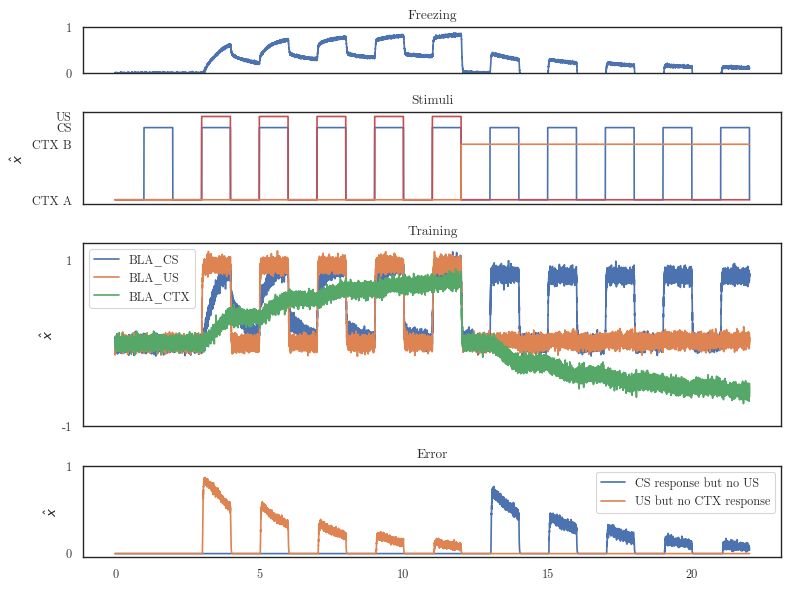

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [1,2,4,2]})
axes[0].plot(sim.trange(), sim.data[pFreeze])
axes[0].set(yticks=((0, 1)), ylim=((0,1)), ylabel=None, title="Freezing")
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[pBLA][:,0], label="BLA_CS")
axes[2].plot(sim.trange(), sim.data[pBLA][:,1], label="BLA_US")
axes[2].plot(sim.trange(), sim.data[pBLA][:,2], label="BLA_CTX")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
# axes[3].plot(sim.trange(), sim.data[pError_CS_fear], label="US but no CS response")
# axes[3].plot(sim.trange(), sim.data[pError_CS_safe], label="CS response but no CS")
axes[3].plot(sim.trange(), sim.data[pError_CTX_safe], label="CS response but no US")
axes[3].plot(sim.trange(), sim.data[pError_CTX_fear], label="US but no CTX response")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()

## Single Model

In [12]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    T1 = int(2/dt)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2 = int((2+2*nCond)/dt)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    T3 = int((2+2*nCond+2*nExt)/dt)
    print("test (CTX A)")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 0
    sim.run(2)
    T4 = int((2+2*nCond+2*nExt+2)/dt)

control
conditioning
extinction
test (CTX A)


### Fear conditioning, extinction, and renewal

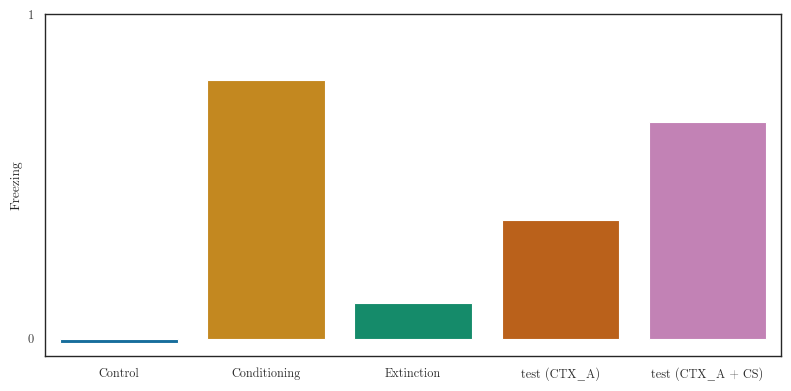

In [13]:
data = pd.DataFrame(columns=["Activity", "Freezing", "Experiment"])
data = data.append({
    "Activity": np.mean(sim.data[pBLA_spikes][0: T1]),
    "Freezing": np.mean(sim.data[pFreeze][0: T1]),
    "Experiment": "Control"},
    ignore_index=True)
data = data.append({
    "Activity": np.mean(sim.data[pBLA_spikes][T2-int(1/dt): T2]),
    "Freezing": np.mean(sim.data[pFreeze][T2-int(1/dt): T2]),
    "Experiment": 'Conditioning'},
    ignore_index=True)
data = data.append({
    "Activity": np.mean(sim.data[pBLA_spikes][T3-int(1/dt): T3]),
    "Freezing": np.mean(sim.data[pFreeze][T3-int(1/dt): T3]),
    "Experiment": 'Extinction'},
    ignore_index=True)
data = data.append({
    "Activity": np.mean(sim.data[pBLA_spikes][T3: T3+int(1/dt)]),
    "Freezing": np.mean(sim.data[pFreeze][T3: T3+int(1/dt)]),
    "Experiment": 'test (CTX_A)'},
    ignore_index=True)
data = data.append({
    "Activity": np.mean(sim.data[pBLA_spikes][T4-int(1/dt): T4]),
    "Freezing": np.mean(sim.data[pFreeze][T4-int(1/dt): T4]),
    "Experiment": 'test (CTX_A + CS)'},
    ignore_index=True)

fig, ax = plt.subplots(figsize=((8,4)))
sns.barplot(data=data, x='Experiment', y="Freezing", palette=palette)
ax.set(xlabel=None, yticks=((0,1)))
plt.tight_layout()

### BLA has "fear", "expression", and "persistent" neurons

18.7% of BLA neurons are 'fear neurons'
22.0% of BLA neurons are 'extinction neurons'
5.0% of BLA neurons are 'persistent neurons'


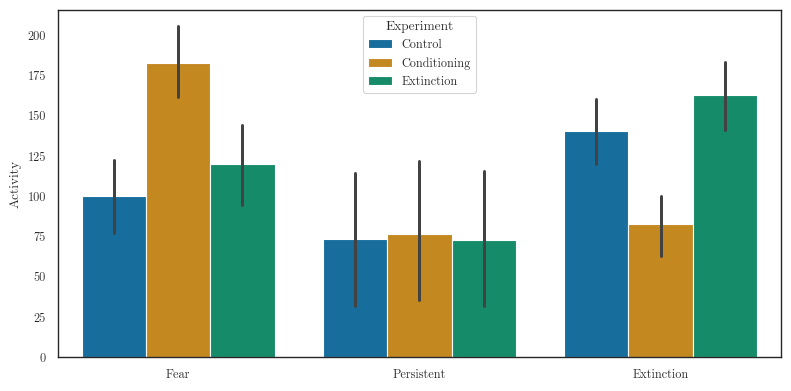

In [14]:
aControl = sim.data[pBLA_spikes][0: T1]
aConditioning = sim.data[pBLA_spikes][T2-int(1/dt): T2]
aExtinction = sim.data[pBLA_spikes][T3-int(1/dt): T3]
neurons = aControl.shape[1]
aThr_pos = 1.2  # neurons are "increasing" if they fire >20% more than the post-conditioning baseline
aThr_neg = 0.8  # neurons are "decreasing" if they fire at <80% of post-conditioning baseline
aThr_same = 0.2  # fear neurons are "persistent" if their mean firing rate changes <20% between conditioning and extinction
fear_neurons = np.where(np.mean(aConditioning, axis=0) > aThr_pos*np.mean(aControl, axis=0))[0]
extinction_neurons = np.where(np.mean(aExtinction, axis=0) > aThr_pos*np.mean(aConditioning, axis=0))[0]
aFear = sim.data[pBLA_spikes][:,fear_neurons]
aFearConditioning = aFear[T2-int(1/dt): T2]
aFearExtinction = aFear[T3-int(1/dt): T3]
persistent_neurons = np.where(np.abs(np.mean(aFearConditioning-aFearExtinction,axis=0))<aThr_same*np.mean(aFearConditioning, axis=0))[0]

print(f"{len(fear_neurons)/neurons*100:.3}% of BLA neurons are 'fear neurons'")
print(f"{len(extinction_neurons)/neurons*100:.3}% of BLA neurons are 'extinction neurons'")
print(f"{len(persistent_neurons)/neurons*100:.3}% of BLA neurons are 'persistent neurons'")

data = pd.DataFrame(columns=["neuron", "type", "Activity", "Experiment"])
for n in fear_neurons:
    data = data.append({"neuron": n, "type": "Fear", "Activity": np.mean(aControl[:,n]), "Experiment": "Control"}, ignore_index=True)
    data = data.append({"neuron": n, "type": "Fear", "Activity": np.mean(aConditioning[:,n]), "Experiment": "Conditioning"}, ignore_index=True)
    data = data.append({"neuron": n, "type": "Fear", "Activity": np.mean(aExtinction[:,n]), "Experiment": "Extinction"}, ignore_index=True)
for n in persistent_neurons:
    data = data.append({"neuron": n, "type": "Persistent", "Activity": np.mean(aControl[:,n]), "Experiment": "Control"}, ignore_index=True)
    data = data.append({"neuron": n, "type": "Persistent", "Activity": np.mean(aConditioning[:,n]), "Experiment": "Conditioning"}, ignore_index=True)
    data = data.append({"neuron": n, "type": "Persistent", "Activity": np.mean(aExtinction[:,n]), "Experiment": "Extinction"}, ignore_index=True)
for n in extinction_neurons:
    data = data.append({"neuron": n, "type": "Extinction", "Activity": np.mean(aControl[:,n]), "Experiment": "Control"}, ignore_index=True)
    data = data.append({"neuron": n, "type": "Extinction", "Activity": np.mean(aConditioning[:,n]), "Experiment": "Conditioning"}, ignore_index=True)
    data = data.append({"neuron": n, "type": "Extinction", "Activity": np.mean(aExtinction[:,n]), "Experiment": "Extinction"}, ignore_index=True)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((8,4)))
sns.barplot(data=data, x='type', y="Activity", hue="Experiment", palette=palette, ax=ax)
ax.set(xlabel=None)
plt.tight_layout()

## Data collection from many models

In [66]:
def run(data_freeze, data_activity, data_counts, seed=0, learning_rate=1e-4):
    
    print(f"seed = {seed}")
    dt = 0.001
    nCond = 5
    nExt = 5
    nNeurons = 100
    dim_CS = 3
    dim_CTX = 10
    nCTX = 2
    inputs = Inputs(nCS=1, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, seed=seed)
    intercepts_pos = nengo.dists.Uniform(0, 1)
    encoders_pos = nengo.dists.Choice([[1]])
    encoders_ctx = nengo.dists.Choice(inputs.CTXs)
    intercepts_ctx = [(np.dot(inputs.CTXs, inputs.CTXs.T) - np.eye(nCTX)).flatten().max()]*dim_CTX*nNeurons
    dInh = -2e0*np.ones((nNeurons, 1))
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.01
    net.config[nengo.Probe].synapse = 0.01

    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        # external ensembles
        external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_ctx, encoders=encoders_ctx)
        # amygdala ensembles
        BLA = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
        gate = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        freeze = nengo.Ensemble(nNeurons, 1)  # [freeze]

        # error ensembles
        error_CS_fear = nengo.Ensemble(nNeurons, 1)
        error_CTX_fear = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        error_CTX_safe = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(CTX, external_CTX, synapse=None)
        nengo.Connection(external_US, BLA[1])
        nengo.Connection(external_CS, gate[0], function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, gate[1]) 
        # learned connections
        conditioning = nengo.Connection(external_CS, BLA[0], function=lambda x: 0, learning_rule_type=nengo.PES(learning_rate))
        extinction = nengo.Connection(external_CTX, BLA[2], function=lambda x: 0, learning_rule_type=nengo.PES(0.1*learning_rate))
        # error connections
        nengo.Connection(BLA, error_CS_fear, function=lambda x: x[1]-x[0])  # US - (CS response)
        nengo.Connection(BLA, error_CTX_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
        nengo.Connection(BLA, error_CTX_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
        # error gating
        nengo.Connection(gate, error_CS_fear.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS
        nengo.Connection(gate, error_CTX_safe.neurons, function=lambda x: 1-x[0]+x[1], transform=dInh)  # inhibit by default; release if CS without US
        nengo.Connection(gate, error_CTX_fear.neurons, function=lambda x: 1-x[1], transform=dInh)  # inhibit unless US
        # error update
        nengo.Connection(error_CS_fear, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CTX_safe, extinction.learning_rule, transform=1)
        nengo.Connection(error_CTX_fear, extinction.learning_rule, transform=-1)
        # output connections
        nengo.Connection(BLA[0], freeze, transform=0.5)  # CS response added to freeze response
        nengo.Connection(BLA[2], freeze, transform=0.5)  # CTX response added to freeze response

        # probes
        pCS = nengo.Probe(CS, synapse=None)
        pUS = nengo.Probe(US, synapse=None)
        pCTX = nengo.Probe(CTX, synapse=None)
        pBLA_spikes = nengo.Probe(BLA.neurons)
        pBLA = nengo.Probe(BLA)
        pError_CS_fear = nengo.Probe(error_CS_fear)
        pError_CTX_fear = nengo.Probe(error_CTX_fear)
        pError_CTX_safe = nengo.Probe(error_CTX_safe)
        pFreeze = nengo.Probe(freeze)
        
    sim = nengo.Simulator(net, dt=dt, progress_bar=False)
    with sim:
#         print("control")
        inputs.CTX = inputs.CTXs[0]
        sim.run(2)
        T1 = int(2/dt)
#         print("conditioning")
        inputs.CTX = inputs.CTXs[0]
        inputs.US = 1
        for p in range(nCond):
            sim.run(2)
        T2 = int((2+2*nCond)/dt)
#         print("extinction")
        inputs.CTX = inputs.CTXs[1]
        inputs.US = 0
        for p in range(nExt):
            sim.run(2)
        T3 = int((2+2*nCond+2*nExt)/dt)
#         print("test")
        inputs.CTX = inputs.CTXs[0]
        inputs.US = 0
        sim.run(2)
        T4 = int((2+2*nCond+2*nExt+2)/dt)
        
    data_freeze = data_freeze.append({"seed": seed, "Freezing": np.mean(sim.data[pFreeze][0: T1]), "Experiment": "Control"},ignore_index=True)
    data_freeze = data_freeze.append({"seed": seed, "Freezing": np.mean(sim.data[pFreeze][T2-int(1/dt): T2]), "Experiment": 'Conditioning'}, ignore_index=True)
    data_freeze = data_freeze.append({"seed": seed, "Freezing": np.mean(sim.data[pFreeze][T3-int(1/dt): T3]), "Experiment": 'Extinction'}, ignore_index=True)
    data_freeze = data_freeze.append({"seed": seed, "Freezing": np.mean(sim.data[pFreeze][T3: T3+int(1/dt)]), "Experiment": 'test (CTX_A)'}, ignore_index=True)
    data_freeze = data_freeze.append({"seed": seed, "Freezing": np.mean(sim.data[pFreeze][T4-int(1/dt): T4]), "Experiment": 'test (CTX_A + CS)'}, ignore_index=True)
    
    aControl = sim.data[pBLA_spikes][0: T1]
    aConditioning = sim.data[pBLA_spikes][T2-int(1/dt): T2]
    aExtinction = sim.data[pBLA_spikes][T3-int(1/dt): T3]
    neurons = aControl.shape[1]
    aThr_pos = 1.2  # neurons are "increasing" if they fire >20% more than the post-conditioning baseline
    aThr_neg = 0.8  # neurons are "decreasing" if they fire at <80% of post-conditioning baseline
    aThr_same = 0.2  # fear neurons are "persistent" if their mean firing rate changes <20% between conditioning and extinction
    fear_neurons = np.where(np.mean(aConditioning, axis=0) > aThr_pos*np.mean(aControl, axis=0))[0]
    extinction_neurons = np.where(np.mean(aExtinction, axis=0) > aThr_pos*np.mean(aConditioning, axis=0))[0]
    aFear = sim.data[pBLA_spikes][:,fear_neurons]
    aFearConditioning = aFear[T2-int(1/dt): T2]
    aFearExtinction = aFear[T3-int(1/dt): T3]
    persistent_neurons = np.where(np.abs(np.mean(aFearConditioning-aFearExtinction,axis=0))<aThr_same*np.mean(aFearConditioning, axis=0))[0]
 
    data_activity = data_activity.append({"seed": seed, "Type": "Fear", "Activity": np.mean(aControl[:,fear_neurons]), "Experiment": "Control"}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "Fear", "Activity": np.mean(aConditioning[:,fear_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "Fear", "Activity": np.mean(aExtinction[:,fear_neurons]), "Experiment": "Extinction"}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "Persistent", "Activity": np.mean(aControl[:,persistent_neurons]), "Experiment": "Control"}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "Persistent", "Activity": np.mean(aConditioning[:,persistent_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "Persistent", "Activity": np.mean(aExtinction[:,persistent_neurons]), "Experiment": "Extinction"}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "Extinction", "Activity": np.mean(aControl[:,extinction_neurons]), "Experiment": "Control"}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "Extinction", "Activity": np.mean(aConditioning[:,extinction_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "Extinction", "Activity": np.mean(aExtinction[:,extinction_neurons]), "Experiment": "Extinction"}, ignore_index=True)

    percent_fear = len(fear_neurons)/neurons*100
    percent_extinction = len(extinction_neurons)/neurons*100
    percent_persistent = len(persistent_neurons)/neurons*100
    data_counts = data_counts.append({"seed": seed, "Type": "Fear", "Percent": percent_fear}, ignore_index=True)
    data_counts = data_counts.append({"seed": seed, "Type": "Extinction", "Percent": percent_extinction}, ignore_index=True)
    data_counts = data_counts.append({"seed": seed, "Type": "Persistent", "Percent": percent_persistent}, ignore_index=True)

    return data_freeze, data_activity, data_counts

In [67]:
data_freeze = pd.DataFrame(columns=["seed", "Freezing", "Experiment"])
data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])
data_counts = pd.DataFrame(columns=["seed", "Type", "Percent"])

seeds = 100
rng = np.random.RandomState(seeds)
for s in range(seeds):
    data_freeze, data_activity, data_counts = run(
        data_freeze, data_activity, data_counts, seed=s, learning_rate=rng.uniform(3e-5, 3e-4))

seed = 0
seed = 1
seed = 2
seed = 3
seed = 4
seed = 5
seed = 6
seed = 7
seed = 8
seed = 9
seed = 10
seed = 11
seed = 12
seed = 13
seed = 14
seed = 15
seed = 16
seed = 17
seed = 18
seed = 19
seed = 20
seed = 21
seed = 22
seed = 23
seed = 24
seed = 25
seed = 26
seed = 27
seed = 28
seed = 29
seed = 30
seed = 31
seed = 32
seed = 33
seed = 34
seed = 35
seed = 36
seed = 37
seed = 38
seed = 39
seed = 40
seed = 41
seed = 42
seed = 43
seed = 44
seed = 45
seed = 46
seed = 47
seed = 48
seed = 49
seed = 50
seed = 51
seed = 52
seed = 53
seed = 54
seed = 55
seed = 56
seed = 57
seed = 58
seed = 59
seed = 60
seed = 61
seed = 62
seed = 63
seed = 64
seed = 65
seed = 66
seed = 67
seed = 68
seed = 69
seed = 70
seed = 71
seed = 72
seed = 73
seed = 74
seed = 75
seed = 76
seed = 77
seed = 78
seed = 79
seed = 80
seed = 81
seed = 82
seed = 83
seed = 84
seed = 85
seed = 86
seed = 87
seed = 88
seed = 89
seed = 90
seed = 91
seed = 92
seed = 93
seed = 94
seed = 95
seed = 96
seed = 97
seed = 98
seed = 99


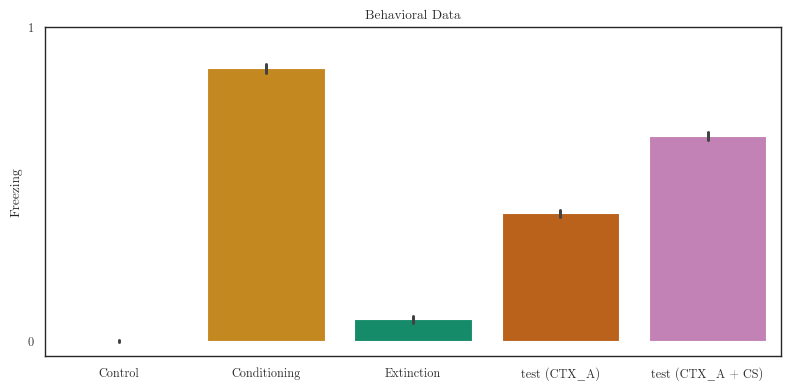

In [68]:
fig, ax = plt.subplots(figsize=((8,4)))
sns.barplot(data=data_freeze, x='Experiment', y="Freezing", palette=palette)
ax.set(xlabel=None, yticks=((0,1)), title="Behavioral Data")
plt.tight_layout()

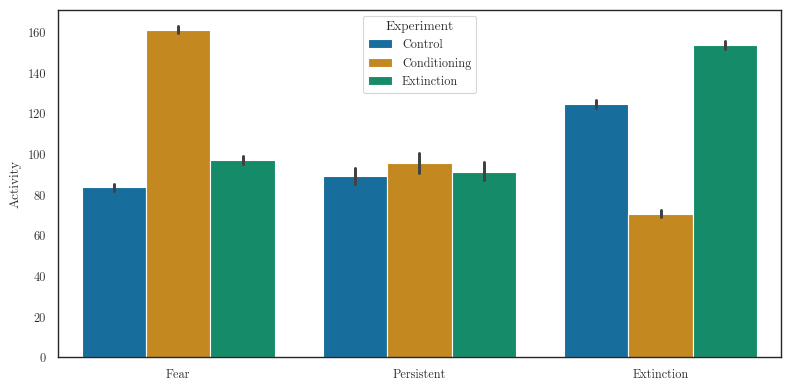

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((8,4)))
sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
ax.set(xlabel=None)
plt.tight_layout()

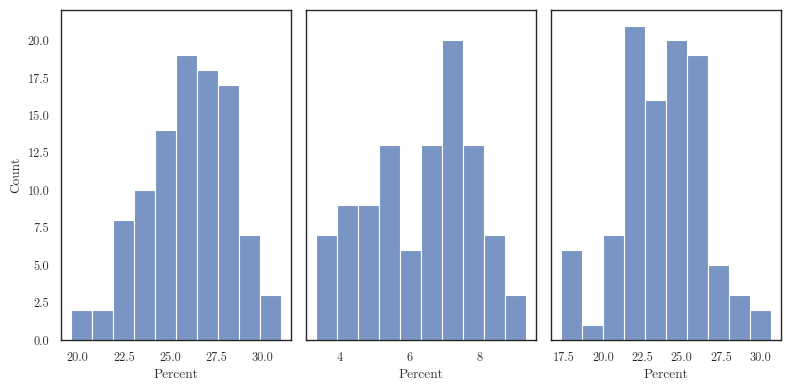

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((8,4)), sharey=True)
sns.histplot(data=data_counts.query("Type=='Fear'")['Percent'], bins=10, ax=axes[0])
sns.histplot(data=data_counts.query("Type=='Persistent'")['Percent'], bins=10, ax=axes[1])
sns.histplot(data=data_counts.query("Type=='Extinction'")['Percent'], bins=10, ax=axes[2])
plt.tight_layout()